In [30]:
import boto3
from IPython.display import Image, display
!pip install textract-trp
from trp import Document
from PIL import Image as PImage, ImageDraw
import time
from IPython.display import IFrame

In [31]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

## 1. Data Capture
Create Amazon S3 Bucket and upload document to your
S3 Bucket for Intelligent document Processing

In [58]:
# Create a Unique S3 bucket

s3BucketName = <YOUR_BUCKET_NAME>
print(s3BucketName)

bookidppackt1234


In [59]:
# Amazon S3 client

s3 = boto3.client('s3')


In [60]:
# Upload document to your S3 Bucket

print(s3BucketName)
!aws s3api create-bucket --bucket {s3BucketName}
!aws s3 cp syncdensetext.png s3://{s3BucketName}/syncdensetext.png

bookidppackt1234
{
    "Location": "/bookidppackt1234"
}
upload: ./syncdensetext.png to s3://bookidppackt1234/syncdensetext.png


## Syncronous Extraction for document

In [62]:
chapter2_syncdensedoc = "syncdensetext.png"
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': chapter2_syncdensedoc})))

In [63]:
# Document Extraction with Amazon Textract

response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': chapter2_syncdensedoc
        }
    })


# Print All the lines
for line in response["Blocks"]:
    if line["BlockType"] == "LINE":
        print (line["Text"])

It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
my
COVID-19
test kits that I have purchased. The next day I went to the post office to send
documents through postal mail to my insurance provider. This made me think, in the 21° st
century we are still working with physical documents. With my approximate math this month
alone, we will get X number of documents per month considering 20% of entire US
population buys a test kit. This is a tons of documents as in this instance. In addition to
physical
copies we have tons of documents which are might be just scanned documents. And
we
are looking for manual processing for these number of documents. Can we do any better
in 21st century to automate the process of these documents?


## Asyncronous Document processing

In [69]:
def startasyncJob(s3BucketName, filename):
    response = None
    response = textract.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': filename
        }
    })

    return response["JobId"]

def isAsyncJobComplete(jobId):
    response = textract.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(10)
        response = textract.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getAsyncJobResult(jobId):

    pages = []
    response = textract.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    ntoken = None
    if('NextToken' in response):
        ntoken = response['NextToken']

    while(ntoken):
        response = textract.get_document_text_detection(JobId=jobId, NextToken=ntoken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            ntoken = response['NextToken']

    return pages

In [70]:
jobId = startasyncJob(s3BucketName, chapter2_syncdensedoc)
print("Started job with id: {}".format(jobId))
if(isAsyncJobComplete(jobId)):
    response = getAsyncJobResult(jobId)

# Print detected text
for resultPage in response:
    for item in resultPage["Blocks"]:
        if item["BlockType"] == "LINE":
            print ('\033[94m' +  item["Text"] + '\033[0m')

Started job with id: 81b88a4fd04693a7ac9902454de8b9697ae70d950f41233cac56da207b8a058b
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
my
COVID-19
test kits that I have purchased. The next day I went to the post office to send
documents through postal mail to my insurance provider. This made me think, in the 21° st
century we are still working with physical documents. With my approximate math this month
alone, we will get X number of documents per month considering 20% of entire US
population buys a test kit. This is a tons of documents as in this instance. In addition to
physical
copies we have tons of documents which are might be just scanned documents. And
we
are looking for manual processing for these number of documents. Can we do any better
in 21st century to automate the process of 

## Sensitive Document Processing. 
Document is stored in local file system. Want to process it Locally without storing in cloud. 

In [73]:
# Document Name
chapter2_sensitivedoc = "sensitive-doc.png"
print(chapter2_sensitivedoc)

sensitive-doc.png


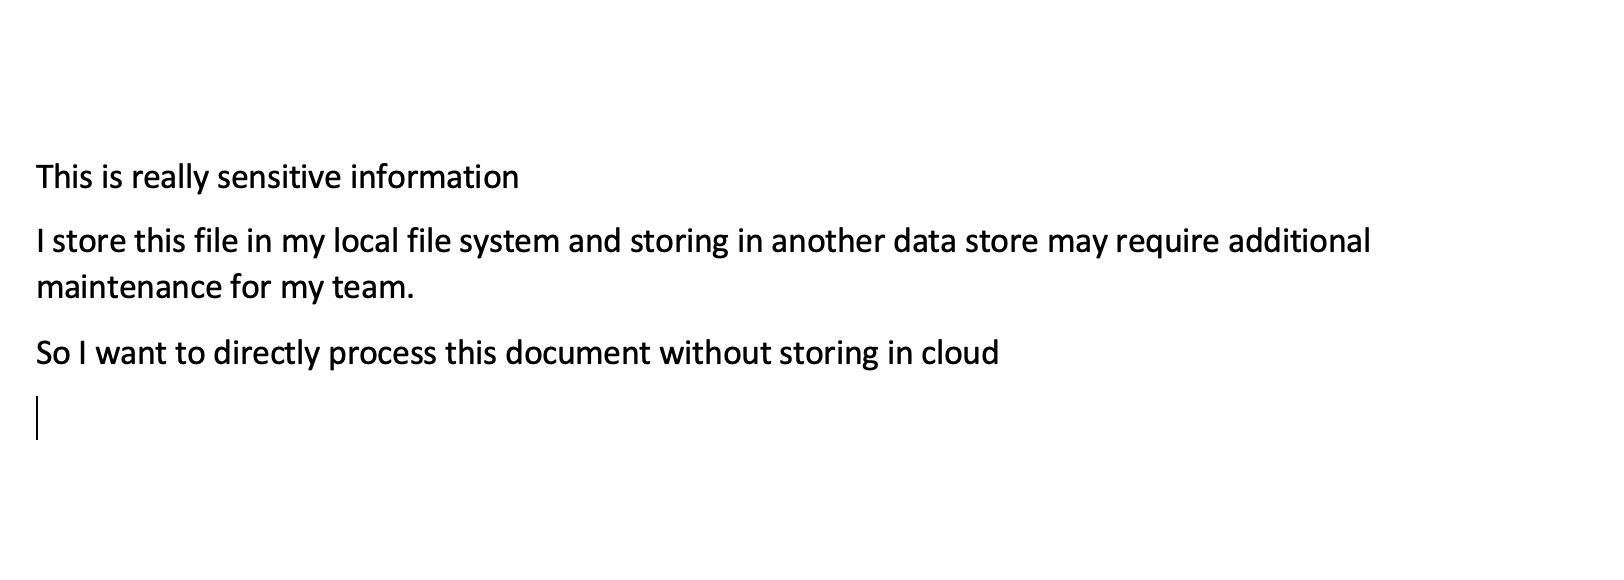

In [74]:
display(Image(filename=chapter2_sensitivedoc))

In [75]:
# Read sensitive document content
with open(chapter2_sensitivedoc, 'rb') as document:
    imgbytes = bytearray(document.read())

# Call Amazon Textract by sending bytes
res = textract.detect_document_text(Document={'Bytes': imgbytes})

# Print detected text
for line in res["Blocks"]:
    if line["BlockType"] == "LINE":
        print (line["Text"])

This is really sensitive information
I store this file in my local file system and storing in another data store may require additional
maintenance for my team.
So I want to directly process this document without storing in cloud


In [ ]:
# Amazon S3 client
s3 = boto3.client('s3')

# Amazon Textract client
textract = boto3.client('textract')

# 1. Detect text from local image

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

In [5]:
# Document
documentName = "simple-document-image.jpg"

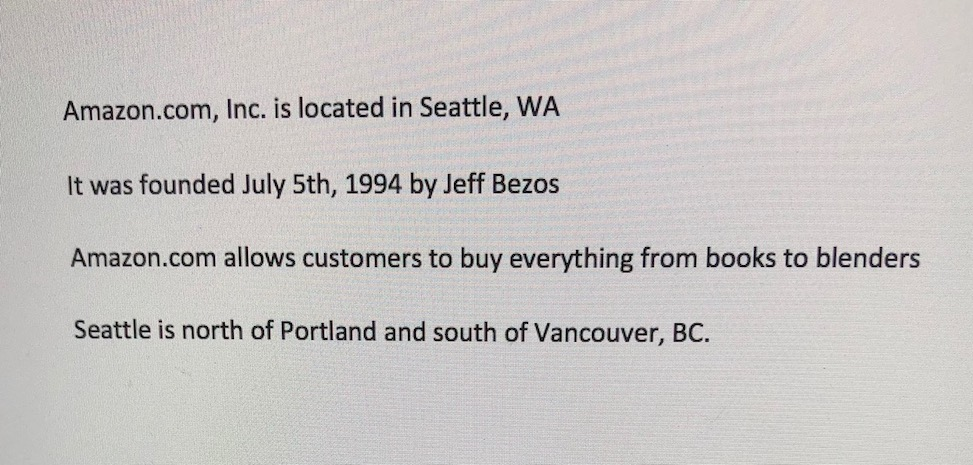

In [6]:
display(Image(filename=documentName))

In [7]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.


# 2. Detect text from S3 object

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

In [6]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [7]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [8]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })


# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.


## Lines and Words of Text - JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/API_BoundingBox.html

https://docs.aws.amazon.com/textract/latest/dg/text-location.html

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-lines-words.html

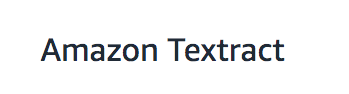

Amazon Textract


In [10]:
# Document
documentName = "OneLine.png"
display(Image(filename=documentName))
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

In [11]:
print("JSON Response\n===================")
display(response)

JSON Response


{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 0.9985673427581787,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 0.0, 'Y': 0.0},
     {'X': 0.9985673427581787, 'Y': 4.546826803444577e-16},
     {'X': 0.9985673427581787, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': 'b39d9aeb-5dd4-488e-9426-8d13741ed10f',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['e2b3389c-c73e-44f4-bb12-476b4e51703f']}]},
  {'BlockType': 'LINE',
   'Confidence': 99.81717681884766,
   'Text': 'Amazon Textract',
   'Geometry': {'BoundingBox': {'Width': 0.7116634845733643,
     'Height': 0.28216034173965454,
     'Left': 0.11438673734664917,
     'Top': 0.39771896600723267},
    'Polygon': [{'X': 0.11438673734664917, 'Y': 0.39771896600723267},
     {'X': 0.8260502219200134, 'Y': 0.39771896600723267},
     {'X': 0.8260502219200134, 'Y': 0.6798793077468872},
     {'X': 0.11438673734664917, 'Y': 0.6798793077468872}]},


# 3. Reading order

In [13]:
# Document
documentName = "textract-samples/two-column-image.jpg"

In [14]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [15]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Detect columns and print lines
columns = []
lines = []
for item in response["Blocks"]:
      if item["BlockType"] == "LINE":
        column_found=False
        for index, column in enumerate(columns):
            bbox_left = item["Geometry"]["BoundingBox"]["Left"]
            bbox_right = item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]
            bbox_centre = item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]/2
            column_centre = column['left'] + column['right']/2

            if (bbox_centre > column['left'] and bbox_centre < column['right']) or (column_centre > bbox_left and column_centre < bbox_right):
                #Bbox appears inside the column
                lines.append([index, item["Text"]])
                column_found=True
                break
        if not column_found:
            columns.append({'left':item["Geometry"]["BoundingBox"]["Left"], 'right':item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]})
            lines.append([len(columns)-1, item["Text"]])

lines.sort(key=lambda x: x[0])
for line in lines:
    print (line[1])

Extract data quickly &
accurately
Textract makes it easy to quickly and
accurately extract data from
documents and forms. Textract
automatically detects a document's
layout and the key elements on the
page, understands the data
relationships in any embedded forms
or tables, and extracts everything
with its context intact. This means
you can instantly use the extracted
data in an application or store it in a
database without a lot of
complicated code in between
No code or templates to
maintain
Textract's pre-trained machine
learning models eliminate the need
to write code for data extraction,
because they have already been
trained on tens of millions of
documents from virtually every
industry, including invoices, receipts,
contracts, tax documents, sales
orders, enrollment forms, benefit
applications, insurance claims, policy
documents and many more. You no
longer need to maintain code for
every document or form you might
receive or worry about how page
layouts change over time.


# 4. Natural Language Processing

In [12]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [13]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [14]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

# Amazon Comprehend client
comprehend = boto3.client('comprehend')

# Detect sentiment
sentiment =  comprehend.detect_sentiment(LanguageCode="en", Text=text)
print ("\nSentiment\n========\n{}".format(sentiment.get('Sentiment')))

# Detect entities
entities =  comprehend.detect_entities(LanguageCode="en", Text=text)
print("\nEntities\n========")
for entity in entities["Entities"]:
    print ("{}\t=>\t{}".format(entity["Type"], entity["Text"]))


Text
Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.

Sentiment
NEUTRAL

Entities
ORGANIZATION	=>	Amazon.com, Inc.
LOCATION	=>	Seattle, WA
DATE	=>	July 5th, 1994
PERSON	=>	Jeff Bezos
ORGANIZATION	=>	Amazon.com
LOCATION	=>	Seattle
LOCATION	=>	Portland
LOCATION	=>	Vancouver, BC


# 5. Comprehend Medical

In [ ]:
# Document
documentName = "textract-samples/medical-notes.png"

In [ ]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [ ]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

# Amazon Comprehend client
comprehend = boto3.client('comprehendmedical')

# Detect medical entities
entities =  comprehend.detect_entities(Text=text)
print("\nMedical Entities\n========")
for entity in entities["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")
    

# 6. Translate

In [ ]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [ ]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [ ]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Amazon Translate client
translate = boto3.client('translate')

print ('')
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        result = translate.translate_text(Text=item["Text"], SourceLanguageCode="en", TargetLanguageCode="de")
        print ('\033[92m' + result.get('TranslatedText') + '\033[0m')
    print ('')

# 7. Search

See code sample at link below:

https://github.com/aws-samples/amazon-textract-code-samples/blob/master/python/07-search.py

# 8. Forms: Key/Values

https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html

In [15]:
# Document
documentName = "textract-samples/employmentapp.png"

In [16]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [20]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Get field by key
    print("\nGet Field by Key:")
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    print("\nSearch Fields:")
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

Fields:
Key: Home Address:, Value: 123 Any Street, Any Town, USA
Key: Mailing Address:, Value: same as home address
Key: Phone Number:, Value: 555-0100
Key: Full Name:, Value: Jane Doe

Get Field by Key:
Key: Phone Number:, Value: 555-0100

Search Fields:
Key: Home Address:, Value: 123 Any Street, Any Town, USA
Key: Mailing Address:, Value: same as home address


## Form Data (Key-Value Pairs) JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-kvp.html

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-selectables.html


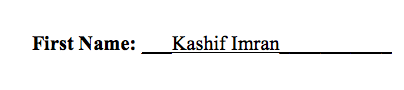

Fields:
Key: First Name:, Value: Kashif Imran


In [22]:
# Document
documentName = "OneKeyValue.png"
display(Image(filename=documentName))
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes}, FeatureTypes=["FORMS"])

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

In [23]:
print("JSON Response\n===================")
display(response)

JSON Response


{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 2.7281736782256487e-17, 'Y': 0.0},
     {'X': 1.0, 'Y': 5.497303649382309e-16},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': '82e9cece-8158-4727-ac00-a252d2d417f5',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['f61aa7e4-d34c-4a58-887f-f29e8b2c97fc',
      '277cde27-1683-4958-8613-90183c63780e',
      '240fbc25-2ef9-4c3f-b5e9-8c0e2f9cf84b',
      '3e60921e-996c-4179-9561-595de331f501']}]},
  {'BlockType': 'LINE',
   'Confidence': 99.86605072021484,
   'Text': 'First Name:',
   'Geometry': {'BoundingBox': {'Width': 0.2617547810077667,
     'Height': 0.19944661855697632,
     'Left': 0.07699709385633469,
     'Top': 0.38779181241989136},
    'Polygon': [{'X': 0.07699709385633469, 'Y': 0.38779181241989136},
     {'X': 0.338751882314682, 'Y': 0.38779181241989136},
     {'X':

https://github.com/aws-samples/amazon-textract-response-parser

https://github.com/aws-samples/amazon-textract-response-parser/blob/master/src-python/trp.py

# 9. Control and Compliance - Redaction

In [ ]:
# Document
documentName = "employmentapp.png"

In [ ]:
display(Image(filename=documentName))

In [ ]:
# Call Amazon Textract
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes}, FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

# Redact document
img = PImage.open(documentName)

width, height = img.size

if(doc.pages):
    page = doc.pages[0]
    for field in page.form.fields:
        if(field.key and field.value and "address" in field.key.text.lower()):
            print("Redacting => Key: {}, Value: {}".format(field.key.text, field.value.text))
            
            x1 = field.value.geometry.boundingBox.left*width
            y1 = field.value.geometry.boundingBox.top*height-2
            x2 = x1 + (field.value.geometry.boundingBox.width*width)+5
            y2 = y1 + (field.value.geometry.boundingBox.height*height)+2

            draw = ImageDraw.Draw(img)
            draw.rectangle([x1, y1, x2, y2], fill="Black")

outputDocumentName = "redacted-{}".format(documentName)
img.save(outputDocumentName)
display(Image(filename=outputDocumentName))

# 10. Tables

In [24]:
# Document
documentName = "textract-samples/employmentapp.png"

In [25]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [26]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"])

#print(response)

doc = Document(response)

for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))

Table[0][0] = Start Date 
Table[0][1] = End Date 
Table[0][2] = Employer Name 
Table[0][3] = Position Held 
Table[0][4] = Reason for leaving 
Table[1][0] = 1/15/2009 
Table[1][1] = 6/30/2011 
Table[1][2] = Any Company 
Table[1][3] = Assistant Baker 
Table[1][4] = Family relocated 
Table[2][0] = 7/1/2011 
Table[2][1] = 8/10/2013 
Table[2][2] = Best Corp. 
Table[2][3] = Baker 
Table[2][4] = Better opportunity 
Table[3][0] = 8/15/2013 
Table[3][1] = present 
Table[3][2] = Example Corp. 
Table[3][3] = Head Baker 
Table[3][4] = N/A, current employer 


# Table JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-tables.html

# 11. Table Data Validation

In [27]:
# Document
documentName = "textract-samples/expense.png"

In [28]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [29]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"])

#print(response)

doc = Document(response)

def isFloat(input):
  try:
    float(input)
  except ValueError:
    return False
  return True

warning = ""
for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            itemName  = ""
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))
                if(c == 0):
                    itemName = cell.text
                elif(c == 4 and isFloat(cell.text)):
                    value = float(cell.text)
                    if(value > 1000):
                        warning += "{} is greater than $1000.".format(itemName)
if(warning):
    print("\nReview needed:\n====================\n" + warning)

Table[0][0] = 
Table[0][1] = 
Table[0][2] = Expense Report 
Table[0][3] = 
Table[0][4] = 
Table[1][0] = Expense Description 
Table[1][1] = Type 
Table[1][2] = Date 
Table[1][3] = Merchant Name 
Table[1][4] = Amount (USD) 
Table[2][0] = Furniture (Desks and Chairs) 
Table[2][1] = Office Supplies 
Table[2][2] = 5/10/1019 
Table[2][3] = Merchant One 
Table[2][4] = 1500.00 
Table[3][0] = Team Lunch 
Table[3][1] = Food 
Table[3][2] = 5/11/2019 
Table[3][3] = Merchant Two 
Table[3][4] = 100.00 
Table[4][0] = Team Dinner 
Table[4][1] = Food 
Table[4][2] = 5/12/2019 
Table[4][3] = Merchant Three 
Table[4][4] = 300.00 
Table[5][0] = Laptop 
Table[5][1] = Office Supplies 
Table[5][2] = 5/13/2019 
Table[5][3] = Merchant Three 
Table[5][4] = 200.00 
Table[6][0] = 
Table[6][1] = 
Table[6][2] = 
Table[6][3] = 
Table[6][4] = 
Table[7][0] = 
Table[7][1] = 
Table[7][2] = 
Table[7][3] = 
Table[7][4] = 
Table[8][0] = 
Table[8][1] = 
Table[8][2] = 
Table[8][3] = 
Table[8][4] = 
Table[9][0] = 
Table[9][1] 

# 12. PDF Processing

https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentAnalysis.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentAnalysis.html

In [ ]:
def startJob(s3BucketName, objectName):
    response = None
    response = textract.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': objectName
        }
    })

    return response["JobId"]

def isJobComplete(jobId):
    response = textract.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getJobResults(jobId):

    pages = []
    response = textract.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    print("Resultset page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        response = textract.get_document_text_detection(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']

    return pages

In [ ]:
# Document
documentName = "textract-samples/Amazon-Textract-Pdf.pdf"

In [ ]:
IFrame(s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName}), 900, 400)

In [ ]:
jobId = startJob(s3BucketName, documentName)
print("Started job with id: {}".format(jobId))
if(isJobComplete(jobId)):
    response = getJobResults(jobId)

#print(response)

# Print detected text
for resultPage in response:
    for item in resultPage["Blocks"]:
        if item["BlockType"] == "LINE":
            print ('\033[94m' +  item["Text"] + '\033[0m')

# GitHub repo with samples in other languages

In [ ]:
https://github.com/aws-samples/amazon-textract-code-samples